# Project Title: 
# Chest X-Ray Masks and Labels – Lung Segmentation & Disease Classification

Team details: Group-6

Team members:
    - Ved Prakash Dwivedi
    - Anugrah Rastogi
    - Malla Manu

Team GitHub Link: https://github.com/vedpd/AAI521-Group6-ComputerVision-Project 

# Project sections:
1. Project Selection and Initializations
2. Exploratory Data Analysis (EDA) and Preprocessing
3. Model Development and Training
4. Model Validation and Performance Evaluation

# 1. Project Initialization:


### Initializations: 




#### Libraries


In [83]:
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import measure, morphology
import random
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    _ALB_AVAILABLE = True
except Exception:
    _ALB_AVAILABLE = False
    
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from typing import Tuple, Dict, Any
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2

In [24]:
# Folders paths configuration.
BASE_PATH = Path(".")     # current folder

IMG_DIR  = BASE_PATH / "CXR_png"
MASK_DIR   = BASE_PATH / "masks"
OUT_DIR = BASE_PATH / "preproc"               # preproc outputs
OUT_IMG = OUT_DIR / "Outimages"
OUT_MASK = OUT_DIR / "Outmasks"
OUT_MASKED = OUT_DIR / "Outmasked"
OUT_CSV = BASE_PATH / "index_clean.csv"
OUT_VIS_DIR = BASE_PATH / "mask_visuals"



#### Image–Mask Pairing Logic:

In [4]:
IMG_EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}

In [5]:
def list_files(folder: Path, exts: Optional[set]=None, recursive: bool=False) -> List[Path]:
    """Return sorted list of files in folder with allowed extensions."""
    exts = exts or IMG_EXTS
    if not folder.exists():
        return []
    if recursive:
        files = [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in exts]
    else:
        files = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in exts]
    return sorted(files)

In [ ]:
#Pair images and masks by exact basename (stem).
def pair_by_basename(img_dir: Path, mask_dir: Path, exts: Optional[set]=None) -> List[Dict]:
    exts = exts or IMG_EXTS
    imgs = list_files(img_dir, exts=exts, recursive=False)
    masks = list_files(mask_dir, exts=exts, recursive=False)
    mask_map = {m.stem: m for m in masks}
    pairs = []
    for im in imgs:
        m = mask_map.get(im.stem)
        if m:
            pairs.append({"image": im, "mask": m})
    return pairs

In [ ]:
#Pair masks to images using mask names as source (handles mask suffix variants).
def pair_masks_to_images(img_dir: Path, mask_dir: Path, variants: List[str]=["_mask","-mask"], exts: Optional[set]=None) -> List[Dict]:

    exts = exts or IMG_EXTS
    imgs = list_files(Path(img_dir), exts=exts, recursive=False)
    masks = list_files(Path(mask_dir), exts=exts, recursive=False)
    img_map = {i.stem: i for i in imgs}
    pairs = []
    for m in masks:
        stem = m.stem
        # direct match
        if stem in img_map:
            pairs.append({"image": img_map[stem], "mask": m})
            continue
        # try variants: if mask is "name_mask" match to "name"
        matched = False
        for v in variants:
            if stem.endswith(v):
                candidate = stem[:-len(v)]
                if candidate in img_map:
                    pairs.append({"image": img_map[candidate], "mask": m})
                    matched = True
                    break
        if not matched:
            # split on variant occurrences (e.g., name_mask_extra)
            for v in variants:
                if v in stem:
                    candidate = stem.split(v)[0]
                    if candidate in img_map:
                        pairs.append({"image": img_map[candidate], "mask": m})
                        matched = True
                        break
    return pairs

In [ ]:
 # Split list into valid pairs (both files exist) and invalid pairs.
def verify_pairs(pairs: List[Dict]) -> Tuple[List[Dict], List[Dict]]:

    valid, invalid = [], []
    for e in pairs:
        im = Path(e["image"]); m = Path(e["mask"])
        if im.exists() and m.exists():
            valid.append(e)
        else:
            invalid.append(e)
    return valid, invalid

In [10]:
# Remove pairs where the image or mask cannot be read by cv2 or is too small.
def remove_corrupt_images(pairs: List[Dict], min_h: int=16, min_w: int=16) -> List[Dict]:
    cleaned = []
    for e in pairs:
        im_path = Path(e["image"])
        m_path  = Path(e["mask"])
        try:
            im = cv2.imread(str(im_path), cv2.IMREAD_UNCHANGED)
            m  = cv2.imread(str(m_path), cv2.IMREAD_UNCHANGED)
            if im is None or m is None:
                continue
            h,w = im.shape[:2]
            mh,mw = m.shape[:2]
            if h < min_h or w < min_w or mh < min_h or mw < min_w:
                continue
            cleaned.append(e)
        except Exception:
            continue
    return cleaned


In [11]:
# Save pairs to CSV with absolute paths (image,mask).
def save_index(pairs: List[Dict], out_csv: Path):
    df = pd.DataFrame([{"image": str(Path(e["image"]).resolve()), "mask": str(Path(e["mask"]).resolve())} for e in pairs])
    df.to_csv(out_csv, index=False)


In [ ]:
"""
    Build index_clean.csv
      - "basename": image->mask exact basename
      - "variants": image->mask with suffix variants
      - "masks_as_source": iterate masks and map masks->images
      - "recursive": recursive pairing
"""
def build_clean_index(img_dir: Path,
                      mask_dir: Path,
                      out_csv: Path,
                      strategy: str="basename",
                      allow_variants: bool=True,
                      recursive: bool=False,
                      min_h: int=16, min_w: int=16) -> Dict:
    img_dir = Path(img_dir); mask_dir = Path(mask_dir)
    if strategy == "basename":
        pairs = pair_by_basename(img_dir, mask_dir)
        if allow_variants and len(pairs) < 200:
            extra = pair_masks_to_images(img_dir, mask_dir)
            seen = {str(p["mask"].resolve()) for p in pairs}
            for p in extra:
                if str(p["mask"].resolve()) not in seen:
                    pairs.append(p)
    elif strategy == "masks_as_source":
        pairs = pair_masks_to_images(img_dir, mask_dir)
    elif strategy == "recursive":
        # recursive pairing using stems
        imgs = list_files(img_dir, recursive=True)
        masks = list_files(mask_dir, recursive=True)
        mask_map = {m.stem: m for m in masks}
        pairs = []
        for im in imgs:
            m = mask_map.get(im.stem)
            if m:
                pairs.append({"image": im, "mask": m})
    else:
        raise ValueError("Unknown strategy: " + str(strategy))

    valid, invalid = verify_pairs(pairs)
    cleaned = remove_corrupt_images(valid, min_h=min_h, min_w=min_w)
    save_index(cleaned, out_csv)

    return {
        "pairs_found": len(pairs),
        "valid": len(valid),
        "invalid": len(invalid),
        "cleaned": len(cleaned),
        "out_csv": str(Path(out_csv).resolve())
    }


In [ ]:
# Apply a binary mask to a grayscale image. Returns masked image.
def apply_mask_to_image(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    if img is None:
        raise ValueError("img is None")
    if mask is None:
        raise ValueError("mask is None")
    mask_u8 = np.where(mask > 127, 255, 0).astype(np.uint8)
    masked = cv2.bitwise_and(img, img, mask=mask_u8)
    return masked

In [ ]:
# Create an RGB overlay (mask highlighted with 'color') over the grayscale image.
def mask_overlay(img: np.ndarray, mask: np.ndarray, color: Tuple[int,int,int]=(255,0,0), alpha: float=0.4) -> np.ndarray:
    if img is None or mask is None:
        raise ValueError("img or mask is None")
    if img.ndim == 2:
        base = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        base = img.copy()
    overlay = base.copy()
    overlay[mask > 127] = color
    out = (base.astype(np.float32) * (1.0 - alpha) + overlay.astype(np.float32) * alpha).astype(np.uint8)
    return out

In [ ]:
# Read an index CSV and create:
#       - masked images (masked by binary mask)
#     - overlay images (visualization) Read an index CSV and create:
#      - masked images (masked by binary mask)
#     - overlay images (visualization)

def create_masked_visuals(index_csv: Path,
                          out_dir: Path,
                          use_preproc: bool = False,
                          overlay_color: Tuple[int,int,int] = (0,0,255),
                          overlay_alpha: float = 0.4,
                          verbose: bool = True) -> pd.DataFrame:
    index_csv = Path(index_csv)
    out_dir = Path(out_dir)
    if not index_csv.exists():
        raise FileNotFoundError(f"Index CSV not found: {index_csv}")
    df = pd.read_csv(index_csv)
    img_col = "image_preproc" if use_preproc and "image_preproc" in df.columns else "image"
    mask_col = "mask_preproc" if use_preproc and "mask_preproc" in df.columns else "mask"

    out_masked_dir = out_dir / "masked"
    out_overlay_dir = out_dir / "overlay"
    out_masked_dir.mkdir(parents=True, exist_ok=True)
    out_overlay_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    for i, r in df.iterrows():
        img_path = Path(r[img_col])
        mask_path = Path(r[mask_col])
        if not img_path.exists() or not mask_path.exists():
            if verbose:
                print(f"Skipping missing: {img_path.name} / {mask_path.name}")
            continue
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            if verbose:
                print(f"Unreadable files: {img_path} or {mask_path}")
            continue
        mask_bin = np.where(mask > 127, 255, 0).astype(np.uint8)
        masked_img = apply_mask_to_image(img, mask_bin)
        overlay_img = mask_overlay(img, mask_bin, color=overlay_color, alpha=overlay_alpha)
        masked_out = out_masked_dir / img_path.name
        overlay_out = out_overlay_dir / img_path.name
        cv2.imwrite(str(masked_out), masked_img)
        cv2.imwrite(str(overlay_out), overlay_img)
        rows.append({
            "image": str(img_path.resolve()),
            "mask": str(mask_path.resolve()),
            "masked_path": str(masked_out.resolve()),
            "overlay_path": str(overlay_out.resolve())
        })
    out_df = pd.DataFrame(rows)
    if verbose:
        print(f"Saved {len(out_df)} masked images and overlays to {out_dir}")
    return out_df


In [ ]:
#     List images that have no matching mask by stem or '_mask' / '-mask' variants.
def find_unpaired_images(img_dir: Path, mask_dir: Path) -> List[Path]:

    img_dir = Path(img_dir); mask_dir = Path(mask_dir)
    imgs = list_files(img_dir, recursive=False)
    masks = list_files(mask_dir, recursive=False)
    mask_stems = {m.stem for m in masks}
    unmatched = []
    for im in imgs:
        stem = im.stem
        if stem in mask_stems: 
            continue
        if (stem + "_mask") in mask_stems or (stem + "-mask") in mask_stems:
            continue
        unmatched.append(im)
    return unmatched

In [ ]:
# Compute basic mask coverage stats (mean, median, min, max) using a sample of pairs.
def summarize_mask_coverage(index_csv: Path, sample_n: int = 500) -> Dict:

    index_csv = Path(index_csv)
    if not index_csv.exists():
        raise FileNotFoundError(f"{index_csv} missing")
    df = pd.read_csv(index_csv)
    img_col = "image_preproc" if "image_preproc" in df.columns else "image"
    mask_col = "mask_preproc" if "mask_preproc" in df.columns else "mask"
    sample = df.sample(min(sample_n, len(df)), random_state=1)
    fracs = []
    for _, r in sample.iterrows():
        mask = cv2.imread(r[mask_col], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        frac = (mask > 127).sum() / mask.size
        fracs.append(frac)
    if len(fracs) == 0:
        return {"count": 0}
    return {
        "count": len(fracs),
        "mask_frac_mean": float(np.mean(fracs)),
        "mask_frac_median": float(np.median(fracs)),
        "mask_frac_min": float(np.min(fracs)),
        "mask_frac_max": float(np.max(fracs))
    }

In [28]:
def display_image(img, title="Image"):
    plt.figure(figsize=(5,5))
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [29]:
def display_pair(image_path, mask_path):
    img  = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    masked = apply_mask_to_image(img, mask)
    overlay = mask_overlay(img, mask)

    plt.figure(figsize=(12,8))

    plt.subplot(2,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image"); plt.axis("off")

    plt.subplot(2,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask"); plt.axis("off")

    plt.subplot(2,2,3)
    plt.imshow(masked, cmap='gray')
    plt.title("Masked Image"); plt.axis("off")

    plt.subplot(2,2,4)
    plt.imshow(overlay)
    plt.title("Overlay"); plt.axis("off")

    plt.show()


In [30]:
def display_multiple_pairs(index_csv, n=6):
    df = pd.read_csv(index_csv).sample(n)
    for _, row in df.iterrows():
        display_pair(row["image"], row["mask"])

In [31]:
def display_masked_visuals(visuals_df, n=6):
    df = visuals_df.sample(min(n, len(visuals_df)))
    plt.figure(figsize=(12,8))
    for i, (_, r) in enumerate(df.iterrows(), start=1):
        img = cv2.imread(r["overlay_path"])
        plt.subplot(2,3,i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(Path(r["overlay_path"]).name)
        plt.axis("off")
    plt.show()

In [20]:
summary = build_clean_index(IMG_DIR, MASK_DIR, OUT_CSV, strategy="basename", allow_variants=True)
print("Index summary:", summary)

Index summary: {'pairs_found': 704, 'valid': 704, 'invalid': 0, 'cleaned': 704, 'out_csv': 'D:\\Masters\\C4_AAI_521 Computer Vision\\GroupProject\\ChestX_Ray\\data\\LungSegmentation\\index_clean.csv'}


In [21]:
unmatched = find_unpaired_images(IMG_DIR, MASK_DIR)
print("Unpaired images count:", len(unmatched))
if len(unmatched) > 0:
    print("First 10 unpaired:", [p.name for p in unmatched[:10]])

Unpaired images count: 96
First 10 unpaired: ['CHNCXR_0025_0.png', 'CHNCXR_0036_0.png', 'CHNCXR_0037_0.png', 'CHNCXR_0038_0.png', 'CHNCXR_0039_0.png', 'CHNCXR_0040_0.png', 'CHNCXR_0065_0.png', 'CHNCXR_0181_0.png', 'CHNCXR_0182_0.png', 'CHNCXR_0183_0.png']


In [25]:
visuals_df = create_masked_visuals(OUT_CSV, OUT_VIS_DIR, use_preproc=False)
print("Saved visuals count:", len(visuals_df))

Saved 704 masked images and overlays to mask_visuals
Saved visuals count: 704


In [27]:
stats = summarize_mask_coverage(OUT_CSV, sample_n=300)
print("Mask coverage stats:", stats)

Mask coverage stats: {'count': 300, 'mask_frac_mean': 0.2549522891134809, 'mask_frac_median': 0.25463931529671524, 'mask_frac_min': 0.08350500534023642, 'mask_frac_max': 0.43264911671062184}


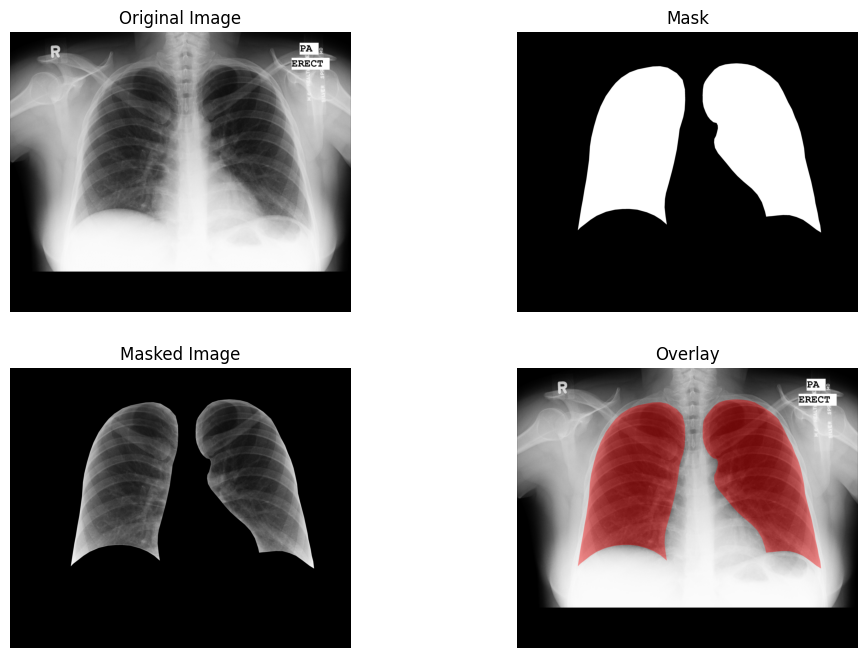

In [34]:
display_pair(
    visuals_df.iloc[0]["image"],
    visuals_df.iloc[0]["mask"]
)

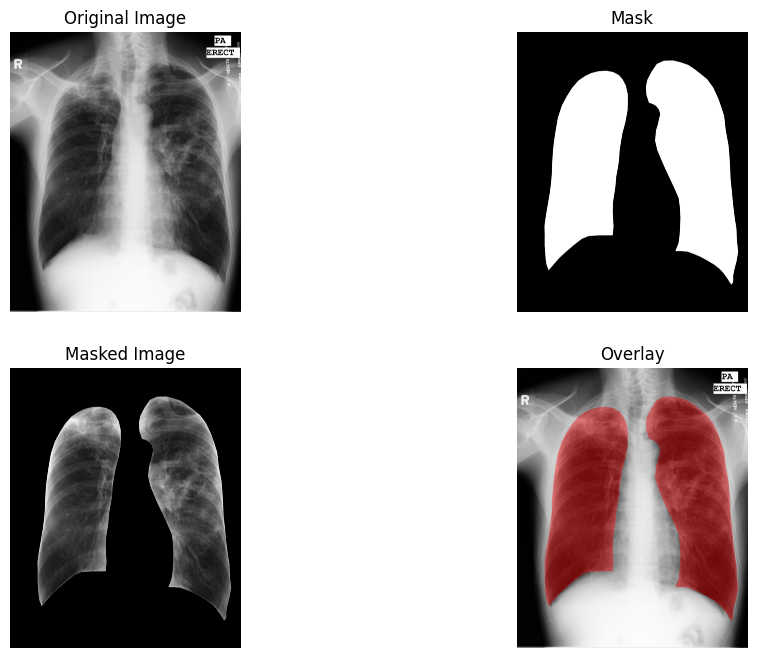

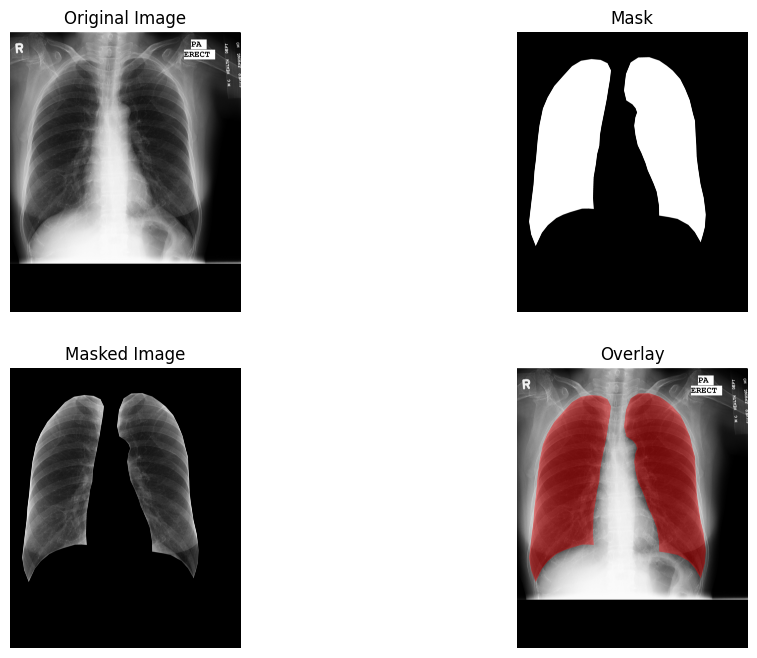

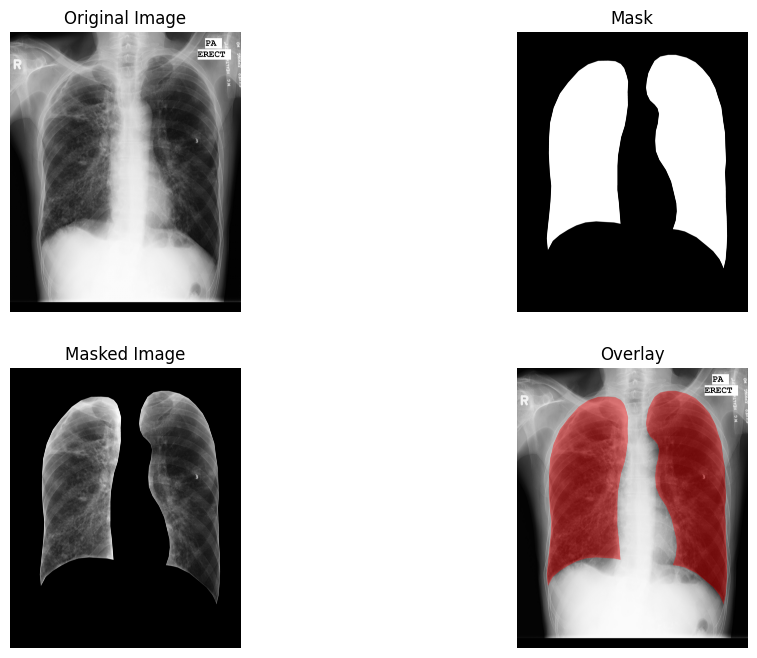

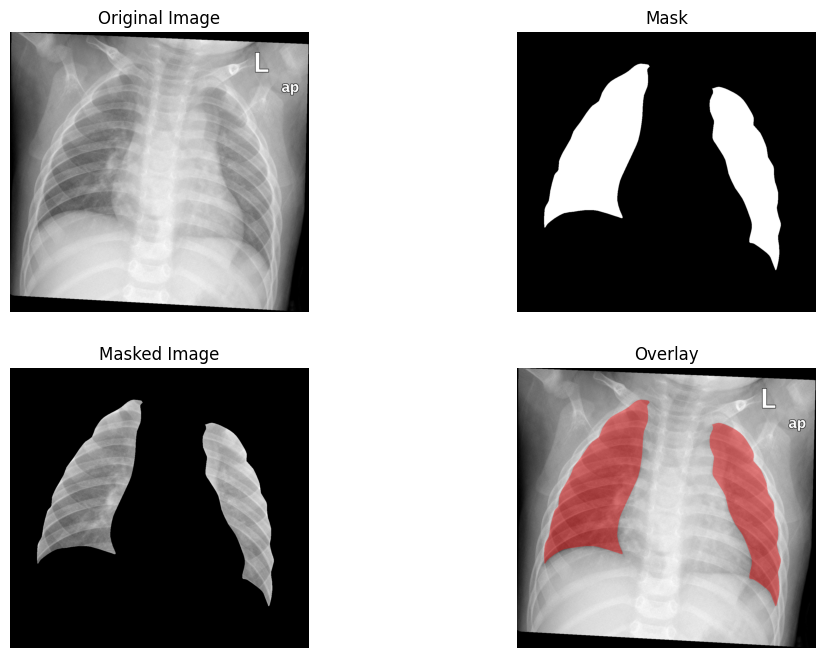

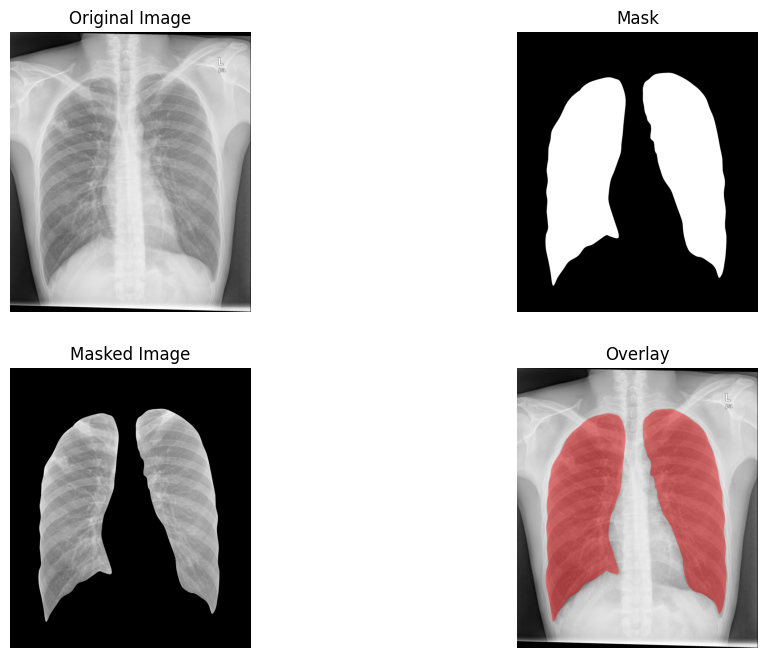

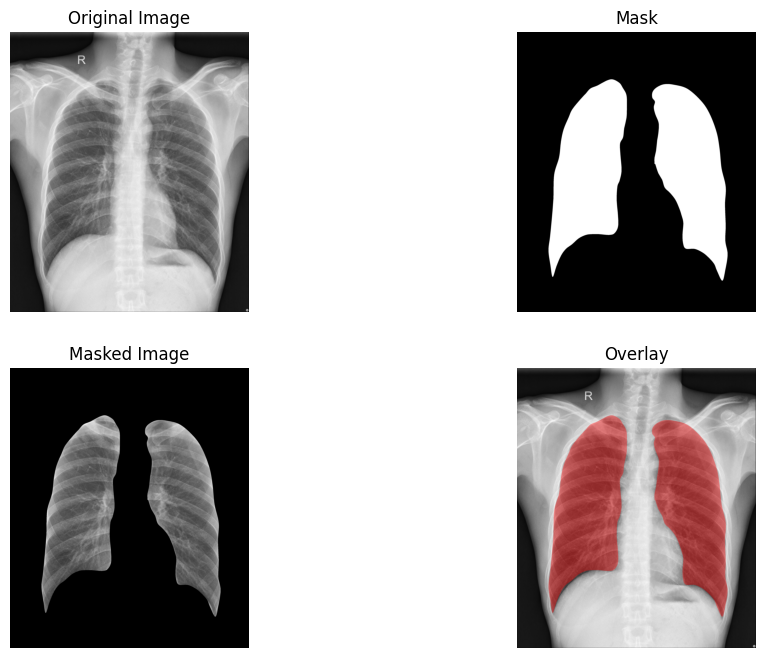

In [35]:
display_multiple_pairs(OUT_CSV, n=6)

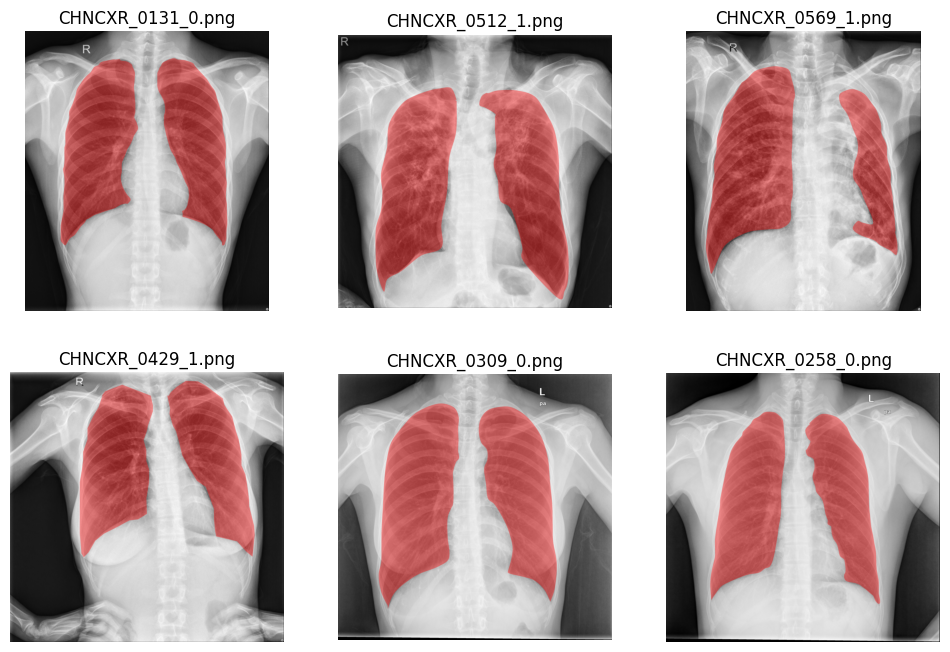

In [36]:
display_masked_visuals(visuals_df, n=6)

In [38]:
coverage_stats = summarize_mask_coverage(OUT_CSV, sample_n=300)
coverage_stats

{'count': 300,
 'mask_frac_mean': 0.2549522891134809,
 'mask_frac_median': 0.25463931529671524,
 'mask_frac_min': 0.08350500534023642,
 'mask_frac_max': 0.43264911671062184}

All the filenames in the CXR_png and masks directories are evaluated.
A consistent one to one mapping between each chest X-ray and its corresponding lung-segmentation mask is constructed.
- 704 valid image-mask pairs 
- 0 invalid or missing pairs
- 0 correpted files
- 100% successfull pairing for all masks preseent int he dataset.

96 images do not have masks which are unlabeled for segmentations.


# EDA - Exploratory Data Analysis:
- Verify image/mask quality, size distributions, mask coverage and visual overlays.

In [16]:
from pathlib import Path
from typing import Tuple, List, Dict, Any, Optional
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

In [ ]:
# CHeck for common preprocessed image column names in a DataFrame.
def _find_preproc_image_column(df: pd.DataFrame) -> Optional[str]:

    candidates = ["image_preproc", "preproc_image", "image_preprocessed", "image", "img", "filepath"]
    for c in candidates:
        if c in df.columns:
            return c

    for c in df.columns:
        if "image" in c.lower() or "img" in c.lower() or "path" in c.lower():
            return c
    return None

In [ ]:
# High-level EDA summary that reuses summarize_mask_coverage() from masking module.
def eda_summary(index_csv: Path, sample_limit: int = 300) -> Dict:

    index_csv = Path(index_csv)
    if not index_csv.exists():
        raise FileNotFoundError(f"index CSV not found: {index_csv}")

    df = pd.read_csv(index_csv)
    total_pairs = len(df)

    
    mask_stats = summarize_mask_coverage(index_csv, sample_n=sample_limit)

    return {
        "total_pairs": int(total_pairs),
        "sampled_for_mask_stats": int(mask_stats.get("count", 0)),
        "mask_frac_mean": float(mask_stats.get("mask_frac_mean")) if mask_stats.get("mask_frac_mean") is not None else None,
        "mask_frac_median": float(mask_stats.get("mask_frac_median")) if mask_stats.get("mask_frac_median") is not None else None,
        "mask_frac_min": float(mask_stats.get("mask_frac_min")) if mask_stats.get("mask_frac_min") is not None else None,
        "mask_frac_max": float(mask_stats.get("mask_frac_max")) if mask_stats.get("mask_frac_max") is not None else None,
        "index_head": df.head().to_dict(orient="records")
    }

In [ ]:
# Plot and return image height/width distributions and mask-area fraction distribution.
def eda_size_and_mask_distributions(index_csv: Path, sample_limit: int = 300, bins: int = 20) -> Dict:
    index_csv = Path(index_csv)
    if not index_csv.exists():
        raise FileNotFoundError(f"index CSV not found: {index_csv}")

    df = pd.read_csv(index_csv)
    sample_df = df.sample(min(sample_limit, len(df)), random_state=1)

    heights, widths, mask_fracs = [], [], []
    for _, row in sample_df.iterrows():
        img_path = row.get("image")
        mask_path = row.get("mask")
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            m = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        except Exception:
            img, m = None, None
        if img is None or m is None:
            continue
        h, w = img.shape[:2]
        heights.append(h); widths.append(w)
        mask_fracs.append((m > 127).sum() / m.size)

    # Plots
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.hist(heights, bins=bins)
    plt.title("Image Height Distribution")
    plt.xlabel("pixels")

    plt.subplot(1,3,2)
    plt.hist(widths, bins=bins)
    plt.title("Image Width Distribution")
    plt.xlabel("pixels")

    plt.subplot(1,3,3)
    plt.hist(mask_fracs, bins=bins)
    plt.title("Mask Area Fraction Distribution")
    plt.xlabel("mask fraction (0-1)")
    plt.tight_layout()
    plt.show()

    return {
        "n_sampled": int(len(heights)),
        "height_mean": float(np.mean(heights)) if heights else None,
        "height_median": float(np.median(heights)) if heights else None,
        "width_mean": float(np.mean(widths)) if widths else None,
        "width_median": float(np.median(widths)) if widths else None,
        "mask_frac_mean": float(np.mean(mask_fracs)) if mask_fracs else None,
        "mask_frac_median": float(np.median(mask_fracs)) if mask_fracs else None
    }

In [ ]:
# Display N random raw image-mask overlay examples.
def eda_show_overlays(index_csv: Path, n: int = 6):

    index_csv = Path(index_csv)
    if not index_csv.exists():
        raise FileNotFoundError(f"index CSV not found: {index_csv}")

    df = pd.read_csv(index_csv)
    sample_df = df.sample(min(n, len(df)), random_state=42)

    for _, row in sample_df.iterrows():
        # display_pair is expected to show original, mask, masked, overlay (4-pane)
        display_pair(row["image"], row["mask"])


In [ ]:
# Ensure masked visuals exist  and display N overlays.
def eda_masked_visuals(index_csv: Path, out_vis_dir: Path, n: int = 6, force_recreate: bool = False):
    index_csv = Path(index_csv)
    out_vis_dir = Path(out_vis_dir)
    if not index_csv.exists():
        raise FileNotFoundError(f"index CSV not found: {index_csv}")

    overlay_dir = out_vis_dir / "overlay"
    masked_dir = out_vis_dir / "masked"

    if force_recreate or (not overlay_dir.exists()) or (not masked_dir.exists()):
        visuals_df = create_masked_visuals(index_csv, out_vis_dir)
    else:
        # Build visuals_df from available overlay/masked files by matching names
        df = pd.read_csv(index_csv)
        rows = []
        for _, r in df.iterrows():
            ov = overlay_dir / Path(r["image"]).name
            ms = masked_dir / Path(r["image"]).name
            if ov.exists() and ms.exists():
                rows.append({
                    "image": r["image"],
                    "mask": r["mask"],
                    "masked_path": str(ms.resolve()),
                    "overlay_path": str(ov.resolve())
                })
        visuals_df = pd.DataFrame(rows)

    # Display using existing display_masked_visuals function (expects visuals_df with overlay_path/masked_path)
    if visuals_df is None or visuals_df.empty:
        print("No visuals found/created.")
    else:
        display_masked_visuals(visuals_df, n=min(n, len(visuals_df)))

    return visuals_df


In [ ]:
# Compute and plot aggregated intensity histogram over preprocessed images.
def intensity_histograms(index_preproc_csv: Path, nbins: int = 256, sample_n: int = 200, show_plot: bool = True):
    index_preproc_csv = Path(index_preproc_csv)
    if not index_preproc_csv.exists():
        raise FileNotFoundError(f"preprocessed index CSV not found: {index_preproc_csv}")

    df = pd.read_csv(index_preproc_csv)
    col = _find_preproc_image_column(df)
    if col is None:
        raise KeyError(f"No preprocessed image column found in {index_preproc_csv}. Columns: {df.columns.tolist()}")

    sample_df = df.sample(min(sample_n, len(df)), random_state=1)
    hist_sum = np.zeros(nbins, dtype=np.float64)
    bins = np.linspace(0, 256, nbins + 1)
    n_read = 0

    for _, row in sample_df.iterrows():
        p = row.get(col)
        if pd.isna(p) or p is None:
            continue
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        h, _ = np.histogram(img.flatten(), bins=bins)
        hist_sum += h
        n_read += 1

    if n_read == 0:
        raise RuntimeError(f"No readable preprocessed images found using column '{col}' in {index_preproc_csv}")

    if show_plot:
        centers = (bins[:-1] + bins[1:]) / 2
        plt.figure(figsize=(8,3))
        plt.bar(centers, hist_sum, width=(bins[1]-bins[0]))
        plt.title(f"Aggregated intensity histogram (n={n_read}) — column: {col}")
        plt.xlabel("Intensity (0-255)")
        plt.ylabel("Count")
        plt.show()

    return {"histogram": hist_sum, "bins": bins, "used_column": col, "n_read": n_read}

In [ ]:
# Compute pixelwise mean and std images across a sample of preprocessed images.
def mean_std_heatmap(index_preproc_csv: Path, sample_n: int = 200, normalize: bool = True, show_plot: bool = True):

    index_preproc_csv = Path(index_preproc_csv)
    if not index_preproc_csv.exists():
        raise FileNotFoundError(f"preprocessed index CSV not found: {index_preproc_csv}")

    df = pd.read_csv(index_preproc_csv)
    col = _find_preproc_image_column(df)
    if col is None:
        raise KeyError(f"No preprocessed image column found in {index_preproc_csv}. Columns: {df.columns.tolist()}")

    paths = df.sample(min(sample_n, len(df)), random_state=1)[col].tolist()
    imgs = []
    for p in paths:
        if pd.isna(p) or p is None:
            continue
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        imf = img.astype(np.float32)
        if normalize:
            imf = imf / 255.0
        imgs.append(imf)

    if len(imgs) == 0:
        raise RuntimeError(f"No readable preprocessed images found using column '{col}' in {index_preproc_csv}")

    # Ensure consistent shape: resize to median-area shape if required
    shapes = [im.shape for im in imgs]
    uniq_shapes = sorted({s for s in shapes}, key=lambda s: s[0]*s[1])
    if len(uniq_shapes) > 1:
        target = uniq_shapes[len(uniq_shapes)//2]
        resized = []
        for im in imgs:
            if im.shape != target:
                scaled = cv2.resize((im * (255.0 if normalize else 1.0)).astype(np.uint8),
                                     (target[1], target[0]), interpolation=cv2.INTER_AREA).astype(np.float32)
                if normalize:
                    scaled = scaled / 255.0
                resized.append(scaled)
            else:
                resized.append(im)
        imgs = resized

    arr = np.stack(imgs, axis=0)  # (N, H, W)
    mean_img = arr.mean(axis=0)
    std_img = arr.std(axis=0)

    if show_plot:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.imshow(mean_img, cmap="gray")
        plt.title(f"Mean image (n={len(imgs)}) — column: {col}")
        plt.axis("off")
        plt.colorbar(fraction=0.046, pad=0.01)

        plt.subplot(1,2,2)
        plt.imshow(std_img, cmap="hot")
        plt.title("Std dev image")
        plt.axis("off")
        plt.colorbar(fraction=0.046, pad=0.01)
        plt.show()

    return {"mean": mean_img, "std": std_img, "used_column": col, "n_read": len(imgs)}


In [ ]:
def run_full_eda_pipeline(BASE: Path,
                          IMG_DIR: str = "CXR_png",
                          MASK_DIR: str = "masks",
                          VIS_DIR: str = "mask_visuals",
                          sample_limit: int = 300,
                          include_preproc: bool = False):
    BASE = Path(BASE)
    index_csv = BASE / "index_clean.csv"
    if not index_csv.exists():
        raise FileNotFoundError(f"index_clean.csv not found at {index_csv}")

    out = {}
    out["summary"] = eda_summary(index_csv, sample_limit=sample_limit)
    out["size_mask_stats"] = eda_size_and_mask_distributions(index_csv, sample_limit=sample_limit)
    # raw overlays
    eda_show_overlays(index_csv, n=6)
    # masked visuals
    vis_out_dir = BASE / VIS_DIR
    visuals_df = eda_masked_visuals(index_csv, vis_out_dir, n=6, force_recreate=False)
    out["visuals_df"] = visuals_df

    # optional preprocessed analysis
    out["preproc"] = None
    if include_preproc:
        preproc_idx = BASE / "preproc" / "index_preproc.csv"
        if preproc_idx.exists():
            out["preproc"] = {
                "intensity": intensity_histograms(preproc_idx, sample_n=200),
                "meanstd": mean_std_heatmap(preproc_idx, sample_n=200)
            }
        else:
            print(f"No preprocessed index found at {preproc_idx} — skipping preproc EDA.")

    return out

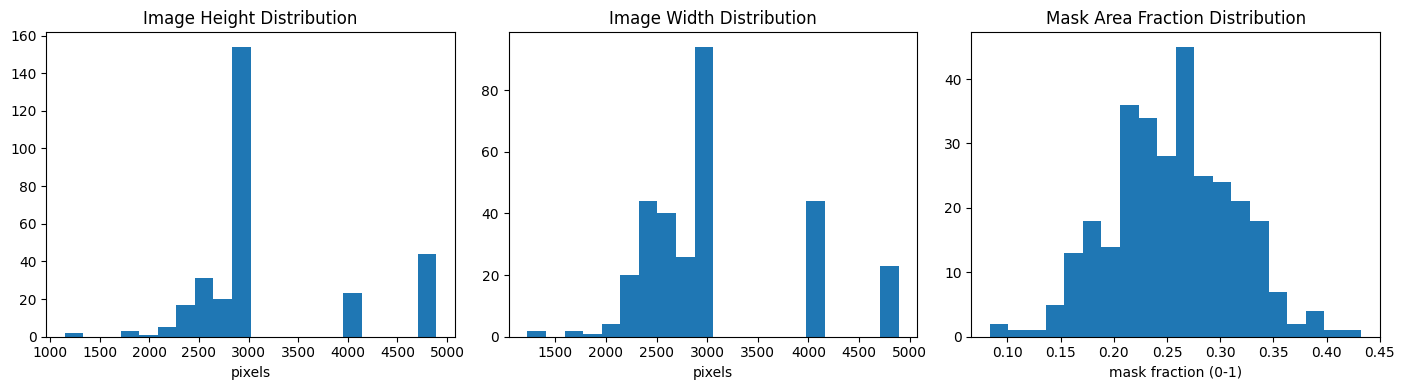

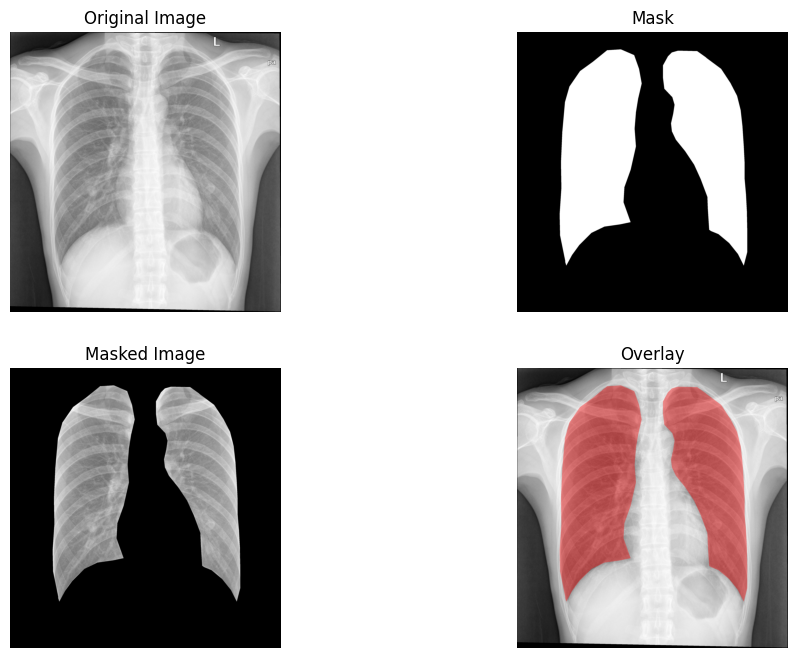

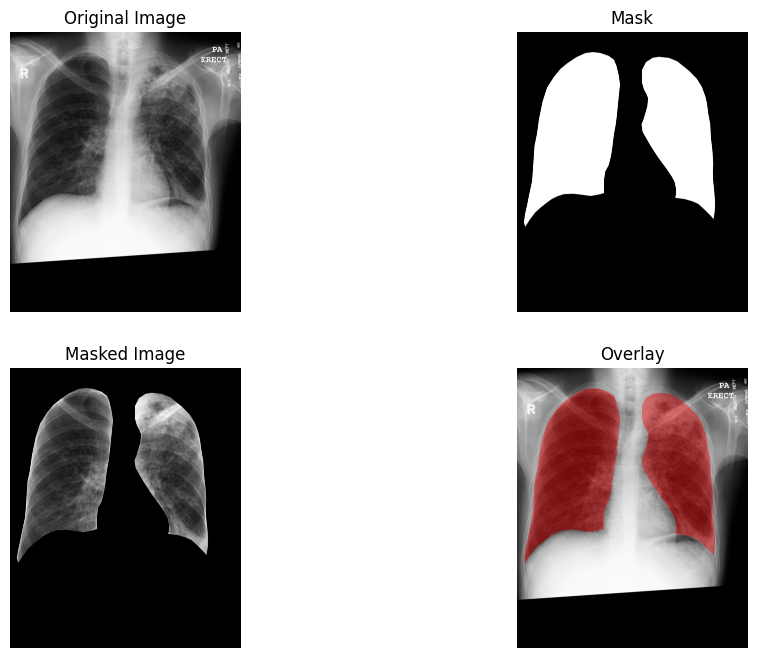

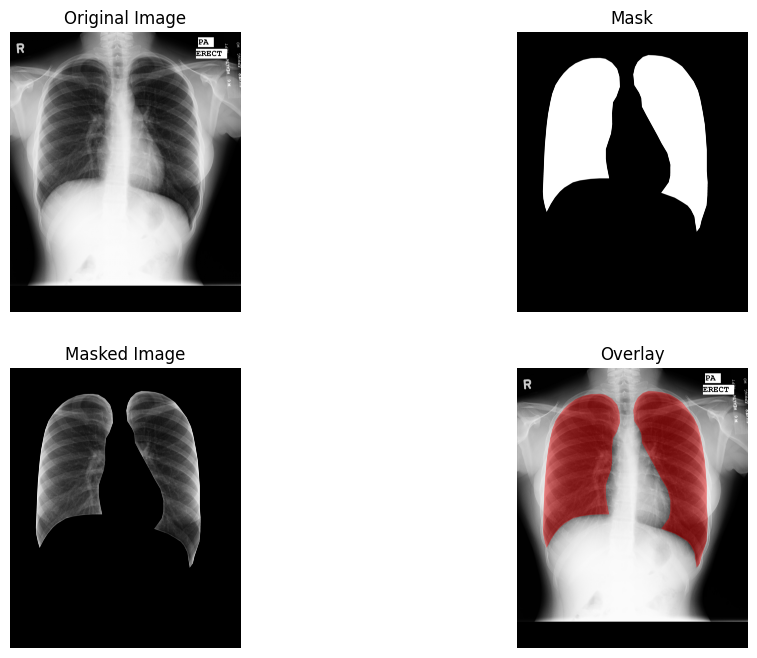

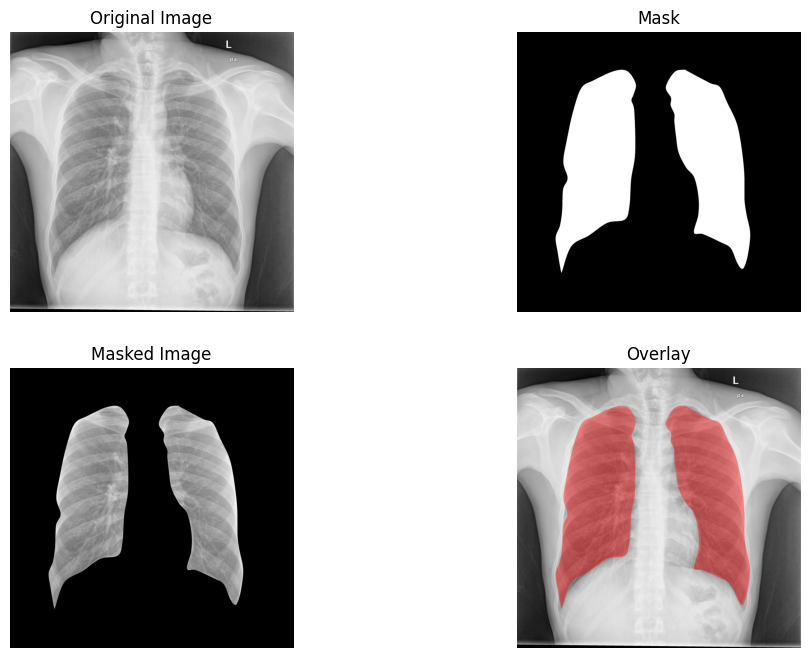

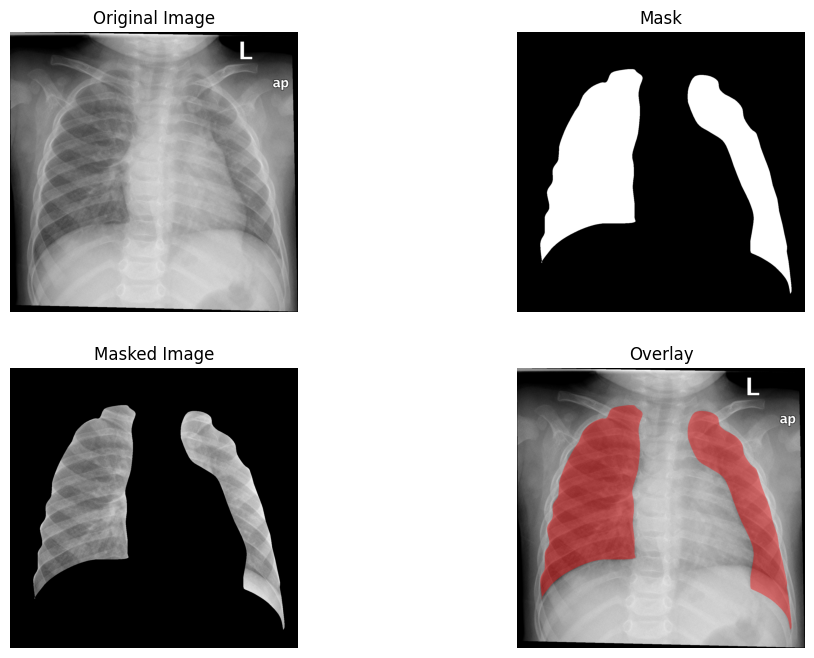

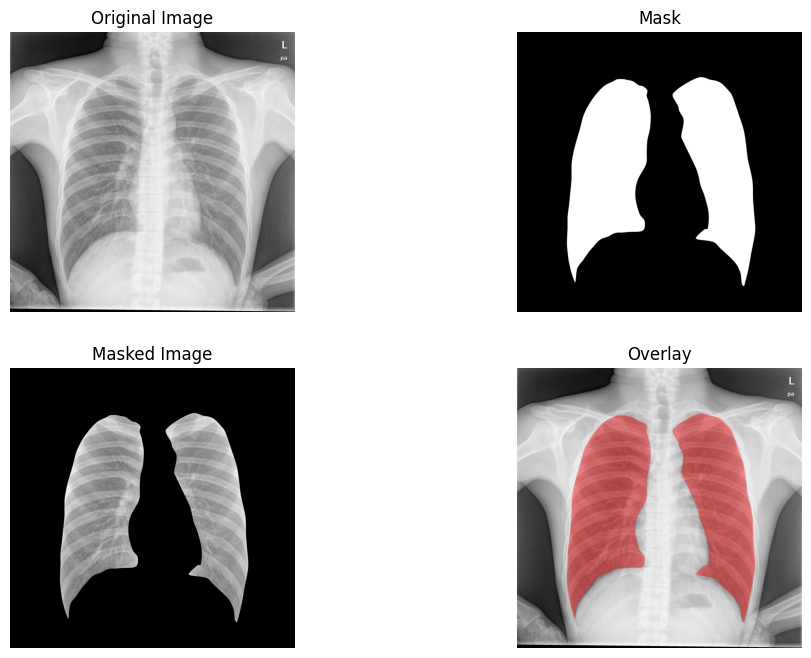

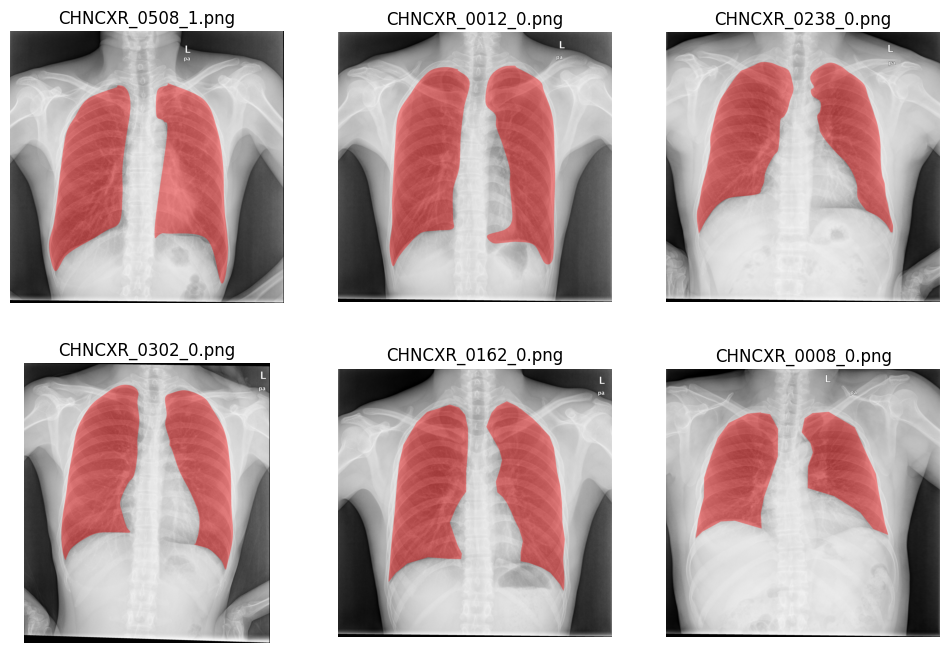

{'summary': {'total_pairs': 704,
  'sampled_for_mask_stats': 300,
  'mask_frac_mean': 0.2549522891134809,
  'mask_frac_median': 0.25463931529671524,
  'mask_frac_min': 0.08350500534023642,
  'mask_frac_max': 0.43264911671062184,
  'index_head': [{'image': 'D:\\Masters\\C4_AAI_521 Computer Vision\\GroupProject\\ChestX_Ray\\data\\LungSegmentation\\CXR_png\\MCUCXR_0001_0.png',
    'mask': 'D:\\Masters\\C4_AAI_521 Computer Vision\\GroupProject\\ChestX_Ray\\data\\LungSegmentation\\masks\\MCUCXR_0001_0.png'},
   {'image': 'D:\\Masters\\C4_AAI_521 Computer Vision\\GroupProject\\ChestX_Ray\\data\\LungSegmentation\\CXR_png\\MCUCXR_0002_0.png',
    'mask': 'D:\\Masters\\C4_AAI_521 Computer Vision\\GroupProject\\ChestX_Ray\\data\\LungSegmentation\\masks\\MCUCXR_0002_0.png'},
   {'image': 'D:\\Masters\\C4_AAI_521 Computer Vision\\GroupProject\\ChestX_Ray\\data\\LungSegmentation\\CXR_png\\MCUCXR_0003_0.png',
    'mask': 'D:\\Masters\\C4_AAI_521 Computer Vision\\GroupProject\\ChestX_Ray\\data\\LungS

In [68]:
results = run_full_eda_pipeline(BASE=BASE_PATH,
                                IMG_DIR="CXR_png",
                                MASK_DIR="masks",
                                VIS_DIR="mask_visuals",
                                sample_limit=300,
                                include_preproc=False)  # change to True only if preproc index exists

results

### EDA summary:
The EDA provides several insights in to the dataset structure, image characterestics and mask quality.

Data size and pairing consistency:
All 704 image-mask pairs are valid and readable. No corrupt or mismatched are present.

Image resolution and distribution:
The image heights range roughly from 1000 to 5000 pixels with cluster around 2900 to 3200 pixels.

Image width range roughly from 1000 to 5000 pixels with a dominant cluster around 2700 to 3100 pixels.

The data set consists of high-resolution chest X-ray images and there is non-uniform image size where preprocessing (resizing) is necessary.

The majproty of omages cluster around similar sizes but there are outliers - reinforcing the need for standardised preprocessing (256x256 or 512x512 resampling).

Mask area fraction distribution: 
The mask fraction (lung area/total image area) ranges from 0.10 to 0.42 with Mean mask coverage = 0.255 (25.5%) and Median mask coverage = 0.255 (25.4%).
On average, Lungs occupy approximately one-quarter of the X-ray image which align with anatomical expectations. 

Overlay visualization:
The red mask regions accurately cover both left and right lung fields. No major leakage into background, ribs or external anatomy. Alignment is anatomically correct and the segmentation boundaries are clean.



# Data Preprocessing:

## Preprocessing description overview:

The dataset contains high-resolution images with varying dimensions and contrast levels, several standardization steps were applied to ensure consistent model inputs.

In [ ]:
# Apply CLAHE to a single-channel uint8 image and return uint8 result.
# Input: img (H,W)
def apply_clahe_to_image(img: np.ndarray, clip_limit: float = 2.0, tile_grid_size: Tuple[int,int] = (8,8)) -> np.ndarray:
    if img is None:
        raise ValueError("img is None")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)

In [ ]:
# Resize image to target_size = (height, width). OpenCV expects (width, height).
def resize_image(img: np.ndarray, size: Tuple[int,int] = (512,512), interp=cv2.INTER_AREA) -> np.ndarray:
    h_target, w_target = size
    return cv2.resize(img, (w_target, h_target), interpolation=interp)

In [ ]:
#  Convert grayscale mask to binary mask with values {0, out_val}.
def binarize_mask(mask: np.ndarray, threshold: int = 127) -> np.ndarray:

    if mask is None:
        raise ValueError("mask is None")
    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, m = cv2.threshold(mask, threshold, 255, cv2.THRESH_BINARY)
    return m.astype(np.uint8)


In [72]:
def compute_mask_fraction(mask: np.ndarray) -> float:
    if mask is None:
        return 0.0
    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return float((mask > 127).sum()) / mask.size

In [ ]:
#    Read an image and mask, apply CLAHE (optional), resize image (linear) and mask (nearest),
 #   and return {'image': img_resized, 'mask': mask_binary}.
def process_pair(image_path: Path,
                 mask_path: Path,
                 out_image_path: Path,
                 out_mask_path: Path,
                 target_size: Tuple[int,int] = (512,512),
                 apply_clahe: bool = True,
                 clahe_clip: float = 2.0,
                 clahe_tile: Tuple[int,int] = (8,8),
                 normalize_to_uint8: bool = True) -> Dict:
    image_path = Path(image_path)
    mask_path = Path(mask_path)
    out_image_path = Path(out_image_path)
    out_mask_path = Path(out_mask_path)

    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        raise FileNotFoundError(f"Could not read image or mask: {image_path}, {mask_path}")

    # CLAHE
    if apply_clahe:
        try:
            img = apply_clahe_to_image(img, clip_limit=clahe_clip, tile_grid_size=clahe_tile)
        except Exception:
            
            pass

    # Resize (to target H,W)
    img_r = resize_image(img, size=target_size, interp=cv2.INTER_AREA)
    mask_r = resize_image(mask, size=target_size, interp=cv2.INTER_NEAREST)

    # Binarize mask
    mask_bin = binarize_mask(mask_r)

    # Save
    out_image_path.parent.mkdir(parents=True, exist_ok=True)
    out_mask_path.parent.mkdir(parents=True, exist_ok=True)

    # Save
    if normalize_to_uint8:
        # img_r CLAHE/resizing
        cv2.imwrite(str(out_image_path), img_r)
    else:
        cv2.imwrite(str(out_image_path), img_r)

    cv2.imwrite(str(out_mask_path), mask_bin)

    mask_frac = compute_mask_fraction(mask_bin)

    return {
        "image_preproc": str(out_image_path.resolve()),
        "mask_preproc": str(out_mask_path.resolve()),
        "mask_frac": mask_frac
    }

In [ ]:
# Process all image-mask pairs from index_csv, save preprocessed images/masks to out_preproc_dir,
def preprocess_and_save(index_csv: Path,
                        out_preproc_dir: Path,
                        target_size: Tuple[int,int] = (512,512),
                        apply_clahe_flag: bool = True,
                        clahe_clip: float = 2.0,
                        clahe_tile: Tuple[int,int] = (8,8),
                        overwrite: bool = False) -> pd.DataFrame:

    index_csv = Path(index_csv)
    out_preproc_dir = Path(out_preproc_dir)
    if not index_csv.exists():
        raise FileNotFoundError(f"Index CSV not found: {index_csv}")

    df = pd.read_csv(index_csv)
    preproc_images_dir = out_preproc_dir / "images"
    preproc_masks_dir = out_preproc_dir / "masks"
    preproc_images_dir.mkdir(parents=True, exist_ok=True)
    preproc_masks_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    for idx, row in df.iterrows():
        src_img = Path(row["image"])
        src_mask = Path(row["mask"])

        # output names keep original basename
        base = src_img.stem
        out_img_path = preproc_images_dir / f"{base}.png"
        out_mask_path = preproc_masks_dir / f"{base}.png"

        if out_img_path.exists() and out_mask_path.exists() and not overwrite:
            # skip processing (read mask frac if present)
            mask_bin = cv2.imread(str(out_mask_path), cv2.IMREAD_GRAYSCALE)
            mask_frac = compute_mask_fraction(mask_bin) if mask_bin is not None else None
            rows.append({
                "image": str(src_img.resolve()),
                "mask": str(src_mask.resolve()),
                "image_preproc": str(out_img_path.resolve()),
                "mask_preproc": str(out_mask_path.resolve()),
                "mask_frac": mask_frac
            })
            continue

        try:
            res = process_pair(src_img, src_mask, out_img_path, out_mask_path,
                               target_size=target_size,
                               apply_clahe=apply_clahe_flag,
                               clahe_clip=clahe_clip,
                               clahe_tile=clahe_tile)
            rows.append({
                "image": str(src_img.resolve()),
                "mask": str(src_mask.resolve()),
                "image_preproc": res["image_preproc"],
                "mask_preproc": res["mask_preproc"],
                "mask_frac": res["mask_frac"]
            })
        except Exception as e:
            # skip problematic file but log
            print(f"[preprocess] Skipped {src_img.name}: {e}")

    out_df = pd.DataFrame(rows)
    out_df.to_csv(out_preproc_dir / "index_preproc.csv", index=False)
    return out_df

In [ ]:
# Albumentations-based augmentation pipeline for image+mask pairs.
def get_augmentations(train: bool = True,
                      p_flip: float = 0.5,
                      p_affine: float = 0.5,
                      max_rotate: int = 15,
                      max_scale: float = 0.10,
                      max_shift: float = 0.10,
                      p_noise: float = 0.25,
                      p_brightness: float = 0.3) -> A.Compose:

    transforms = []
    if train:
        transforms.extend([
            A.HorizontalFlip(p=p_flip),
            A.ShiftScaleRotate(shift_limit=max_shift, scale_limit=max_scale, rotate_limit=max_rotate, p=p_affine, border_mode=cv2.BORDER_CONSTANT),
            A.RandomBrightnessContrast(p=p_brightness),
            A.GaussNoise(p=p_noise),
            # small elastic to simulate slight deformations (kept conservative)
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2)
        ])
    else:
        transforms = []  # minimal/no augmentation for val/test
    return A.Compose(transforms, additional_targets={"mask": "mask"})

In [ ]:
# Apply albumentations augmentation to (image, mask).
def apply_augmentation_to_pair(image: np.ndarray,
                               mask: np.ndarray,
                               aug: A.Compose) -> Tuple[np.ndarray, np.ndarray]:

    if aug is None or len(aug.transforms) == 0:
        return image, mask
    # albumentations expects HxWxC for images; for grayscale supply single channel
    if image.ndim == 2:
        image_in = image
    else:
        image_in = image
    aug_res = aug(image=image_in, mask=mask)
    img_aug = aug_res["image"]
    mask_aug = aug_res["mask"]
    # ensure mask remains binary 0/255
    mask_aug = binarize_mask(mask_aug)
    return img_aug, mask_aug

In [ ]:
# Create augmented images from preprocessed index CSV.
def augment_and_save(index_preproc_csv: Path,
                     out_aug_dir: Path,
                     n_augs_per_image: int = 2,
                     target_size: Tuple[int,int] = (512,512),
                     seed: Optional[int] = 42) -> pd.DataFrame:

    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    index_preproc_csv = Path(index_preproc_csv)
    if not index_preproc_csv.exists():
        raise FileNotFoundError(f"Preproc index not found: {index_preproc_csv}")

    df = pd.read_csv(index_preproc_csv)
    img_col_candidates = ["image_preproc", "preproc_image", "image"]
    img_col = next((c for c in img_col_candidates if c in df.columns), None)
    if img_col is None:
        img_col = df.columns[0]

    out_aug_dir = Path(out_aug_dir)
    aug_images_dir = out_aug_dir / "images"
    aug_masks_dir = out_aug_dir / "masks"
    aug_images_dir.mkdir(parents=True, exist_ok=True)
    aug_masks_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    aug_transform = get_augmentations(train=True)

    for _, r in df.iterrows():
        src_img_path = Path(r[img_col])
        # map mask_preproc column
        mask_col = "mask_preproc" if "mask_preproc" in r.index else ("mask" if "mask" in r.index else None)
        src_mask_path = Path(r[mask_col]) if mask_col else None
        if not src_img_path.exists() or (src_mask_path is None or not src_mask_path.exists()):
            continue

        img = cv2.imread(str(src_img_path), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(src_mask_path), cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            continue

        base = src_img_path.stem
        for k in range(n_augs_per_image):
            img_aug, mask_aug = apply_augmentation_to_pair(img, mask, aug_transform)
            out_img = aug_images_dir / f"{base}_aug{k+1}.png"
            out_mask = aug_masks_dir / f"{base}_aug{k+1}.png"
            cv2.imwrite(str(out_img), img_aug)
            cv2.imwrite(str(out_mask), mask_aug)
            rows.append({
                "image_aug": str(out_img.resolve()),
                "mask_aug": str(out_mask.resolve()),
                "source_image": str(src_img_path.resolve()),
                "mask_frac": compute_mask_fraction(mask_aug)
            })
    out_df = pd.DataFrame(rows)
    out_df.to_csv(out_aug_dir / "index_augmented.csv", index=False)
    return out_df


In [ ]:
# Display N random overlays from preprocessed images and masks.
def show_preproc_overlays(index_preproc_csv: Path, n: int = 6, random_state: int = 42):

    df = pd.read_csv(index_preproc_csv)
    if "image_preproc" in df.columns and "mask_preproc" in df.columns:
        sample = df.sample(n=min(n, len(df)), random_state=random_state)
        for _, r in sample.iterrows():
            img = cv2.imread(r["image_preproc"], cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(r["mask_preproc"], cv2.IMREAD_GRAYSCALE)
            if img is None or mask is None:
                continue
            # Use existing display_pair if available
            try:
                display_pair(r["image_preproc"], r["mask_preproc"])
            except Exception:
                # fallback: plot 4-pane
                masked_img = cv2.bitwise_and(img, img, mask=(mask>127).astype(np.uint8)*255)
                overlay = np.dstack([img, img, img])
                overlay = (overlay * 0.7).astype(np.uint8)
                overlay[mask>127] = (255, 0, 0)  # red-ish
                plt.figure(figsize=(10,8))
                plt.subplot(2,2,1); plt.imshow(img, cmap="gray"); plt.title("Preproc Image"); plt.axis("off")
                plt.subplot(2,2,2); plt.imshow(mask, cmap="gray"); plt.title("Preproc Mask"); plt.axis("off")
                plt.subplot(2,2,3); plt.imshow(masked_img, cmap="gray"); plt.title("Masked"); plt.axis("off")
                plt.subplot(2,2,4); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
                plt.show()
    else:
        raise KeyError("index_preproc.csv must contain 'image_preproc' and 'mask_preproc' columns.")


In [ ]:
# Create train/val/test splits from preprocessed index CSV.
def create_splits(index_preproc_csv: Path,
                  out_dir: Path,
                  train_frac: float = 0.8,
                  val_frac: float = 0.1,
                  test_frac: float = 0.1,
                  stratify_by_mask_frac: bool = True,
                  random_state: int = 42) -> Dict[str, pd.DataFrame]:

    idx = pd.read_csv(index_preproc_csv)
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)

    # if mask_frac not present, compute quickly
    if "mask_frac" not in idx.columns:
        fracs = []
        for _, r in idx.iterrows():
            m = cv2.imread(r["mask_preproc"], cv2.IMREAD_GRAYSCALE)
            fracs.append(compute_mask_fraction(m) if m is not None else 0.0)
        idx["mask_frac"] = fracs

    # create stratify labels if requested
    if stratify_by_mask_frac:
        # quantile buckets
        idx["mask_bucket"] = pd.qcut(idx["mask_frac"].fillna(0.0), q=5, duplicates="drop").astype(str)
        stratify_col = "mask_bucket"
    else:
        stratify_col = None

    # shuffle
    idx = idx.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    n = len(idx)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    # ensure test gets remainder
    n_test = n - n_train - n_val

    train_df = idx.iloc[:n_train].reset_index(drop=True)
    val_df = idx.iloc[n_train:n_train+n_val].reset_index(drop=True)
    test_df = idx.iloc[n_train+n_val:].reset_index(drop=True)

    train_df.to_csv(out_dir / "train.csv", index=False)
    val_df.to_csv(out_dir / "val.csv", index=False)
    test_df.to_csv(out_dir / "test.csv", index=False)

    return {"train": train_df, "val": val_df, "test": test_df}

In [ ]:
INDEX_CSV = BASE_PATH / "index_clean.csv"
PREPROC_DIR = BASE_PATH / "preproc"
    # run preprocessing
out_df = preprocess_and_save(
    INDEX_CSV,
    PREPROC_DIR,
    target_size=(512,512),
    apply_clahe_flag=True,
    clahe_clip=2.0,
    clahe_tile=(8,8),
    overwrite=False
)

print("Rows processed:", len(out_df))
print("Saved preproc index:", (PREPROC_DIR / "index_preproc.csv").exists())
out_df.head()


Rows processed: 704
Saved preproc index: True


image  \
0  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
1  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
2  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
3  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
4  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   

                                                mask  \
0  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
1  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
2  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
3  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
4  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   

                                       image_preproc  \
0  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
1  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
2  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
3  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
4  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   

                                        mask_preproc  mask_frac  
0  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.241684  
1  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.203766  
2  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.254349  
3  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.176880  
4  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.308487

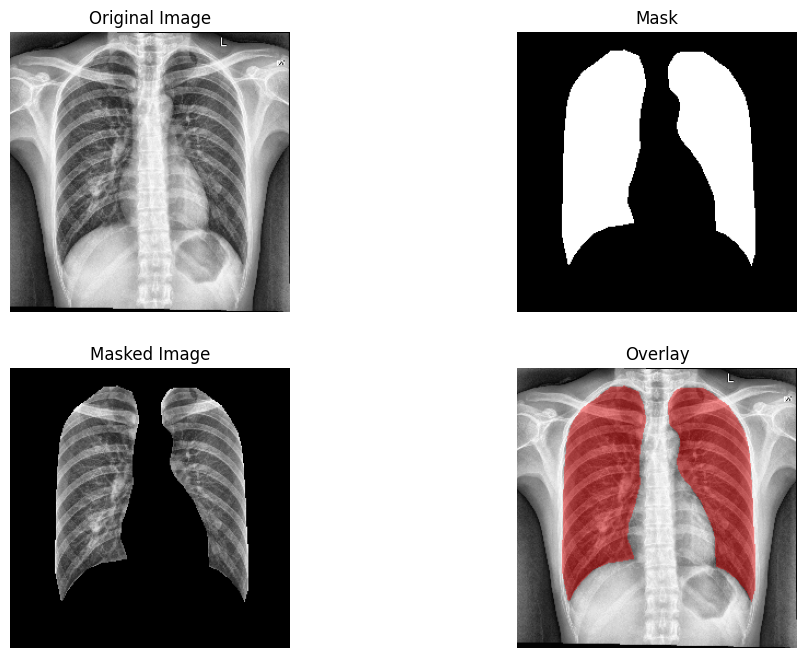

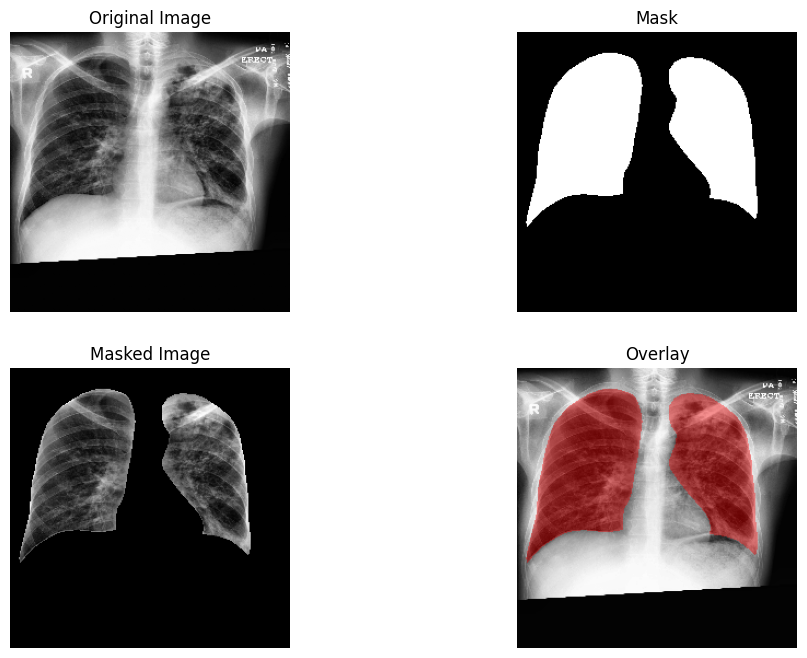

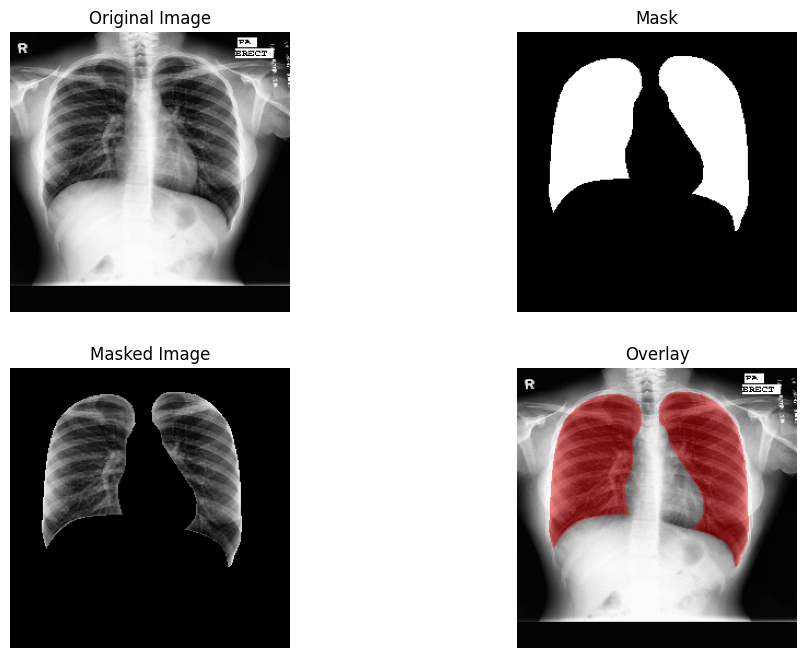

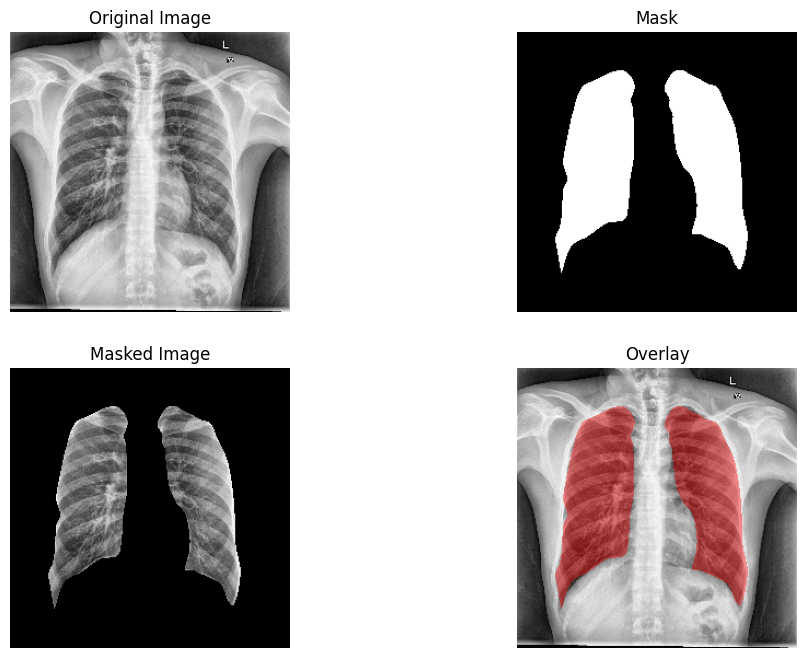

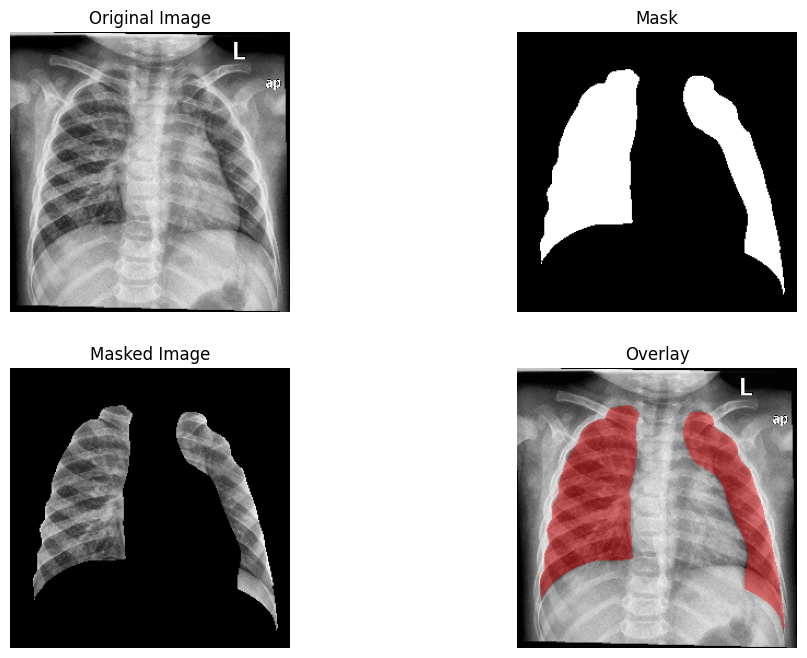

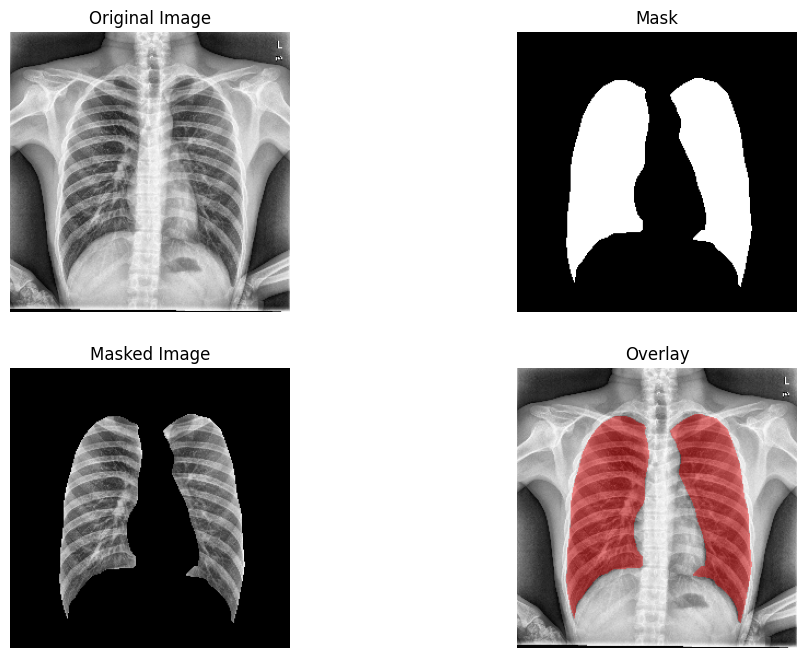

In [87]:
PREPROC_IDX = PREPROC_DIR / "index_preproc.csv"
show_preproc_overlays(PREPROC_IDX, n=6)

In [88]:
AUG_OUT = BASE_PATH / "preproc_aug"
aug_df = augment_and_save(
    PREPROC_IDX,
    AUG_OUT,
    n_augs_per_image=2,
    target_size=(512,512),
    seed=42
)
print("Augmented rows:", len(aug_df))
aug_df.head()

c:\Users\manuk\AppData\Local\Programs\Python\Python313\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\manuk\AppData\Local\Temp\ipykernel_7292\4191646718.py:21: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2)


Augmented rows: 1408


image_aug  \
0  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
1  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
2  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
3  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
4  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   

                                            mask_aug  \
0  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
1  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
2  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
3  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   
4  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   

                                        source_image  mask_frac  
0  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.241684  
1  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.209641  
2  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.209930  
3  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.216415  
4  D:\Masters\C4_AAI_521 Computer Vision\GroupPro...   0.236099

In [89]:
splits = create_splits(
    PREPROC_DIR / "index_preproc.csv",
    out_dir=PREPROC_DIR,
    train_frac=0.8,
    val_frac=0.1,
    test_frac=0.1,
    stratify_by_mask_frac=True,
    random_state=42
)

print("Train / Val / Test sizes:", len(splits["train"]), len(splits["val"]), len(splits["test"]))

Train / Val / Test sizes: 563 70 71


Mask Alignment:
- Each mask correctly overlays the left and right lung regions.
- No visible shift, rotation, or mismatch.

Masks are Clean and Binary:
- Clear boundaries around the lung contour.
- No partial transparency or gray artifacts.

CLAHE + Resizing:
- X-ray structure (ribs, spine, lung fields) is visible even after resizing.
- Contrast looks enhanced.

Images are now uniform in shape (512×512).